In [203]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

# define class where each object holds all the data for a fracture toughness test
class FractureToughness:
    
    def __init__(self, path, S, W, B, a0, cmp=1, E=22.5e3, calc_E=True, start_line=6, multi=False):
        
        self.S = S
        self.W = W
        self.B = B
        self.B_N = B
        self.a0 = a0
        self.cmp = cmp
        self._calc_E = calc_E
        self.E = E
        self.m = self.E
        self._multi = multi
        self.plottable_arrays = {}
        self._start_line = start_line
        
        # define all variables to be filled in later
        self.P_max = None
        self.pl_index = None
        self.time_pl = None
        self.crosshead_pl = None
        self.extenso_pl = None
        self.load_pl = None
        self.crosshead_linearized = None
        self.load_linearized = None
        self.K_ic = None
        self.J_el = None
        self.n_pl = None
        self.J_pl = None
        self.a_crosshead = None
        self.a_CMOD = None
        self.K_jc = None
        self.K_jc_overall = None
        
        # cement-mass-normalized values
        self.load_normalized = None
        self.load_pl_normalized = None
        self.load_linearized_normalized = None
        self.K_ic_normalized = None
        self.K_jc_normalized = None
        self.K_jc_overall_normalized = None
        
        # read data
        self.data = pd.read_csv(path, skiprows=self._start_line)
        self.data = self.data.drop([0])
        
        # get relevant columns and preprocess
        self.time = self.data.loc[:, 'Time '].to_numpy(dtype=np.double)
        self.crosshead = self.data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
        self.extenso = self.data.loc[:, 'Extensometer '].to_numpy(dtype=np.double)
        self.load = self.data.loc[:, 'Load '].to_numpy(dtype=np.double)
        self.preprocess()
        
    def preprocess(self):
        self.crosshead = abs(self.crosshead)
        self.load = abs(self.load)

        min_extenso = np.min(self.extenso)
        if (min_extenso < 0):
            self.extenso = self.extenso + abs(min_extenso)
        self.extenso = abs(self.extenso)
        
        
    # show peak values
    def display_peaks(self):
        peaks, _ = find_peaks(self.load, width=10)

        print(peaks)

        plt.plot(self.crosshead, self.load)
        plt.plot(self.crosshead[peaks], self.load[peaks], 'x')
        plt.show()


    def do_analysis(self, pl_index, stop_index=None):
        
        if (stop_index is not None and stop_index < pl_index):
            raise Exception("stop_index must be greater than pl_index")

        # set peak index and find max load
        self.pl_index = pl_index
        self.P_max = np.max(self.load)

        # make post-peak arrays
        self.crop_arrays(stop_index=stop_index)

        # once peak is found, calculate E using slope (or not)
        if (self._calc_E == True):
            self.E = self.get_E_reg()

        # after E is found, we can linearize the load pre-peak using the calculated slope
        self.crosshead_linearized, self.load_linearized = self.linearize_load(self._calc_E)

        self.plottable_arrays['crosshead_linearized'] = self.crosshead_linearized
        self.plottable_arrays['load_linearized'] = self.load_linearized

        # calculate K_ic for pre-peak behavior
        self.K_ic = self.get_K_ic()

        # get J_el to also characterize pre-peak behavior:
        self.J_el = self.get_J_el()

        # find J_pl array
        self.n_pl = self.load_pl.shape[0]
        self.J_pl = self.get_J_pl()
        self.plottable_arrays['J_pl'] = self.J_pl

        # find cracklength using crosshead method from Bouville et al and using CMOD from E399
        self.a_crosshead = self.get_a_crosshead()
        self.a_CMOD = self.get_a_CMOD()
        self.plottable_arrays['a_crosshead'] = self.a_crosshead
        self.plottable_arrays['a_CMOD'] = self.a_CMOD

        #  put J_el and J_pl together to calculate K_jc
        self.K_jc = np.sqrt((self.J_el+self.J_pl)*self.E)
        self.K_jc_overall = np.max(self.K_jc)
        self.plottable_arrays['K_jc'] = self.K_jc
        
        # normalize all values with cement mass percent
        self.load_normalized = self.load / self.cmp
        self.load_pl_normalized = self.load_pl / self.cmp
        self.load_linearized_normalized = self.load_linearized / self.cmp
        self.K_ic_normalized = self.K_ic / self.cmp
        self.K_jc_normalized = self.K_jc / self.cmp
        self.K_jc_overall_normalized = self.K_jc_overall / self.cmp
        
        # then add to dictionary
        self.plottable_arrays['load_normalized'] = self.load_normalized
        self.plottable_arrays['load_pl_normalized'] = self.load_pl_normalized
        self.plottable_arrays['load_linearized_normalized'] = self.load_linearized_normalized
        self.plottable_arrays['K_jc_normalized'] = self.K_jc_normalized

    
    def crop_arrays(self, stop_index=None):
        
        # find proper stop point
        end = None
        if (self._multi == True): end = stop_index - self._start_line
        else:
            # stop at 20% of peak load for non multi-material samples
            load_thresh = 0.2 * self.P_max
            indices_sub_thresh = np.where(self.load[self.pl_index:] <= load_thresh)[0]
            end = indices_sub_thresh[0] + self.pl_index
        
        
        # start cropping
        self.time = self.time[0:end]
        self.crosshead = self.crosshead[0:end]
        self.extenso = self.extenso[0:end]
        self.load = self.load[0:end]
        
        # add to plotting dictionary
        self.plottable_arrays['time'] = self.time
        self.plottable_arrays['crosshead'] = self.crosshead
        self.plottable_arrays['extenso'] = self.extenso
        self.plottable_arrays['load'] = self.load
        
        # post-peak arrays
        self.time_pl = self.time[self.pl_index:]
        self.crosshead_pl = self.crosshead[self.pl_index:]
        self.extenso_pl = self.extenso[self.pl_index:]
        self.load_pl = self.load[self.pl_index:]
        
        # add to plotting dictionary
        self.plottable_arrays['time_pl'] = self.time_pl
        self.plottable_arrays['crosshead_pl'] = self.crosshead_pl
        self.plottable_arrays['extenso_pl'] = self.extenso_pl
        self.plottable_arrays['load_pl'] = self.load_pl
        
        
    def get_K_ic(self):
        
        a_W = self.a0/self.W
        f_aW = 3*np.sqrt(a_W) * (1.99 - a_W*(1-a_W)*(2.15-3.93*a_W+2.7*a_W**2)) / (2*(1+2*a_W)*np.power(1-a_W, 1.5))
        
        return (self.P_max*self.S/(np.sqrt(self.B*self.B_N)*np.power(self.W, 1.5))) * f_aW
    
    def get_J_el(self):
        return self.K_ic**2 / self.E
        
    def get_E_reg(self):
        #  find slope of linear load-displacement region
        num_reg_points = int(self.pl_index / 5)
        crosshead_reg = self.crosshead[self.pl_index-num_reg_points:self.pl_index]
        load_reg = self.load[self.pl_index-num_reg_points:self.pl_index]
        A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
        self.m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]
        
        # use to calculate E
        return (self.S**3 * self.m) / (4*self.B*self.W**3)
    
    def linearize_load(self, calc_E):
        # find slope if E was never calculated
        if (calc_E == False):
            num_reg_points = int(self.pl_index / 5)
            crosshead_reg = self.crosshead[self.pl_index-num_reg_points:self.pl_index]
            load_reg = self.load[self.pl_index-num_reg_points:self.pl_index]
            A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
            self.m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]
            
        crosshead_peak = self.crosshead[self.pl_index]
        load_peak = self.load[self.pl_index]

        # generate new data values where lead-up to peak is linearized
        crosshead_x_int = crosshead_peak - (load_peak/self.m)

        crosshead_peak = self.crosshead[self.pl_index]
        crosshead_el = np.linspace(0, crosshead_peak-crosshead_x_int, num=self.pl_index)
        load_el = self.m * np.copy(crosshead_el)
        
        # concatenate to post-peak data
        crosshead_linearized = np.concatenate((crosshead_el, self.crosshead_pl-crosshead_x_int))
        load_linearized = np.concatenate((load_el, self.load_pl))

        return np.copy(crosshead_linearized), np.copy(load_linearized)
        
    
    def get_J_pl(self):
        # find trapezoidal sum under load-displacement curve
        A_pl = np.zeros(self.n_pl)
        
        A_pl[0] = 0.5*(self.load[self.pl_index]+self.load[self.pl_index-1]) * \
                      (self.crosshead[self.pl_index]-self.crosshead[self.pl_index-1])
        
        for i in range(1, self.n_pl):
            A_pl[i] = A_pl[i-1] + 0.5*(self.load_pl[i]+self.load_pl[i-1]) * (self.crosshead[i]-self.crosshead[i-1])

        return 1.9*A_pl/(self.B*(self.W-self.a0))
    
    def get_a_crosshead(self):
        C = np.divide(self.crosshead_pl, self.load_pl)

        a = np.zeros(self.n_pl)

        a[0] = self.a0
        for i in range(1, self.n_pl):
            a[i] = a[i-1] + 0.5*(self.W-a[i-1])*((C[i]-C[i-1])/C[i])
        
        # return and subtract a0 to get delta
        return a - self.a0
    
    def get_a_CMOD(self):
        B_e = self.B-((self.B-self.B_N)**2)/self.B

        U = 1/(1+np.sqrt((self.E*B_e*self.extenso_pl*1e1/(self.load_pl+1e-50))) * 4*self.W/self.S)

        # a = (a/W)*W
        a = self.W*(1 - 3.950*U + 2.982*np.power(U, 2) - 3.214*np.power(U, 3) + 5.516*np.power(U, 4) - 113.031*np.power(U, 5))

        offset = abs(a[0] - self.a0)
        if (a[0] < self.a0): a = a + offset
        else: a = a - offset
            
        # return and subtract a0 to get delta
        return a - self.a0
    
        
    def plot(self, x, y, sub, c=None, mc=None):
        x_array = self.plottable_arrays[x]
        y_array = self.plottable_arrays[y]
        
        s = [20*2**n for n in range(len(x_array))]
        
        sub.plot(x_array, y_array, color=c, markerfacecolor=mc, markeredgewidth=0, marker='.', markersize=5)

#         sub.plot(x_array, y_array, color='c', markeredgewidth=0, markerfacecolor='b', marker='.', markersize=5)

        

In [204]:
notched_layered_4 = FractureToughness('Thesis_Samples_Data/Notched_Layered_4/Notched_Layered_4.csv', 90, 23.1, 43.76, 0.76, cmp=0.77, multi=True)
notched_solid_5 = FractureToughness('Thesis_Samples_Data/Notched_Solid_5/Notched_Solid_5.csv', 90, 26.5, 39.97, 0.85)
notched_cast_6 = FractureToughness('Thesis_Samples_Data/Notched_Cast_6/Notched_Cast_6.csv', 90, 26.15, 32.35, 1.2)


[ 2245  3319  5749  6591  6773  7252  7580  8296  8987  9225  9693 10168
 10752 11352 11675 12223 12803 13310 13568 13861 14291 14634 15013 16168
 16637 16788 17146 18348 24328 25917 26630 27094 27417 27850 28629 29816
 30720 32949 33752 34913 37485 38298 38536 38965 39389]


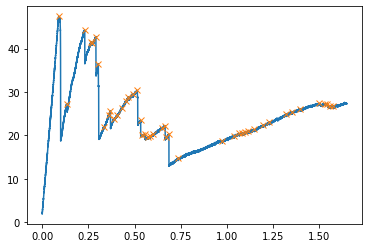

[1915 2161]


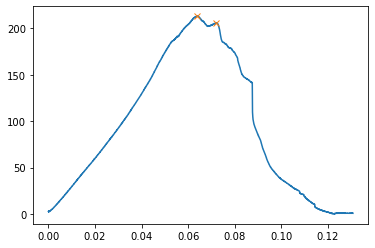

[1697]


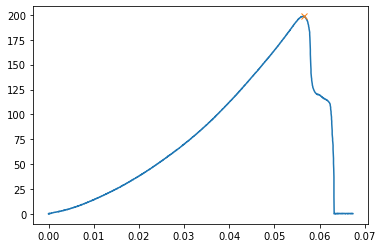

In [205]:
notched_layered_4.display_peaks()
notched_solid_5.display_peaks()
notched_cast_6.display_peaks()

In [206]:
notched_layered_4.do_analysis(2245, stop_index=18125)
notched_solid_5.do_analysis(1915)
notched_cast_6.do_analysis(1697)

Text(0, 0.5, 'load (N)')

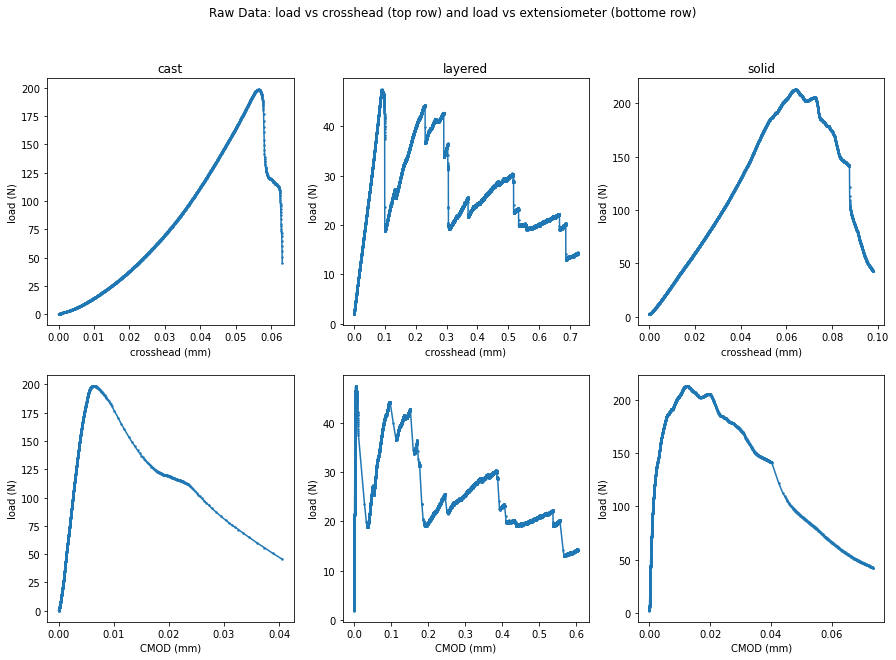

In [207]:
plt.figure(figsize=(15, 10))

plt.suptitle('Raw Data: load vs crosshead (top row) and load vs extensiometer (bottome row)')


sub = plt.subplot(2, 3, 1)
notched_cast_6.plot('crosshead', 'load', sub)
plt.title('cast')
plt.xlabel('crosshead (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 2)
notched_layered_4.plot('crosshead', 'load', sub)
plt.title('layered')
plt.xlabel('crosshead (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 3)
notched_solid_5.plot('crosshead', 'load', sub)
plt.title('solid')
plt.xlabel('crosshead (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 4)
notched_cast_6.plot('extenso', 'load', sub)
plt.xlabel('CMOD (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 5)
notched_layered_4.plot('extenso', 'load', sub)
plt.xlabel('CMOD (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 6)
notched_solid_5.plot('extenso', 'load', sub)
plt.xlabel('CMOD (mm)')
plt.ylabel('load (N)')

Text(0, 0.5, 'load_linearized (N)')

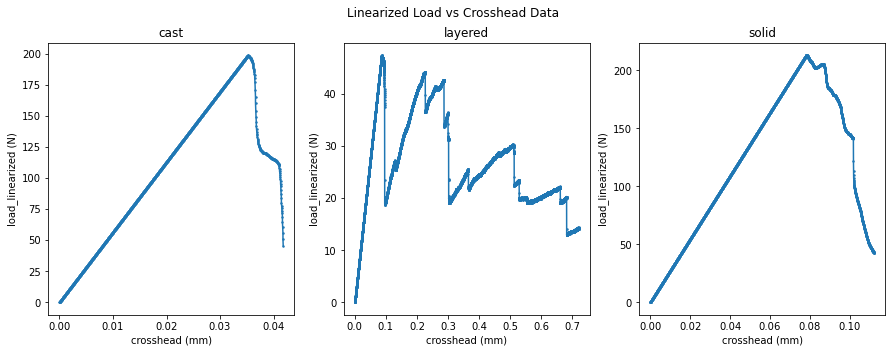

In [208]:
plt.figure(figsize=(15, 5))

plt.suptitle('Linearized Load vs Crosshead Data')


sub = plt.subplot(1, 3, 1)
notched_cast_6.plot('crosshead_linearized', 'load_linearized', sub)
plt.title('cast')
plt.xlabel('crosshead (mm)')
plt.ylabel('load_linearized (N)')

sub = plt.subplot(1, 3, 2)
notched_layered_4.plot('crosshead_linearized', 'load_linearized', sub)
plt.title('layered')
plt.xlabel('crosshead (mm)')
plt.ylabel('load_linearized (N)')


sub = plt.subplot(1, 3, 3)
notched_solid_5.plot('crosshead_linearized', 'load_linearized', sub)
plt.title('solid')
plt.xlabel('crosshead (mm)')
plt.ylabel('load_linearized (N)')


Text(0, 0.5, 'Kjc (MPa*mm^1.5)')

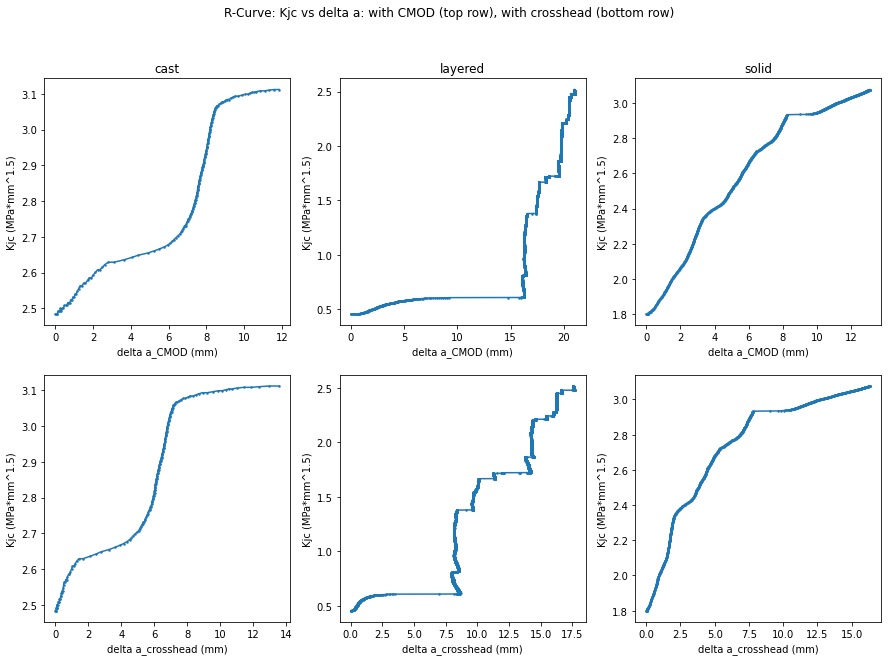

In [210]:
plt.figure(figsize=(15, 10))

plt.suptitle('R-Curve: Kjc vs delta a: with CMOD (top row), with crosshead (bottom row)')

sub = plt.subplot(2, 3, 1)
notched_cast_6.plot('a_CMOD', 'K_jc', sub)
plt.title('cast')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

sub = plt.subplot(2, 3, 2)
notched_layered_4.plot('a_CMOD', 'K_jc', sub)
plt.title('layered')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

sub = plt.subplot(2, 3, 3)
notched_solid_5.plot('a_CMOD', 'K_jc', sub)
plt.title('solid')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

sub = plt.subplot(2, 3, 4)
notched_cast_6.plot('a_crosshead', 'K_jc', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

sub = plt.subplot(2, 3, 5)
notched_layered_4.plot('a_crosshead', 'K_jc', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

sub = plt.subplot(2, 3, 6)
notched_solid_5.plot('a_crosshead', 'K_jc', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('Kjc (MPa*mm^1.5)')

Text(0, 0.5, 'load (N)')

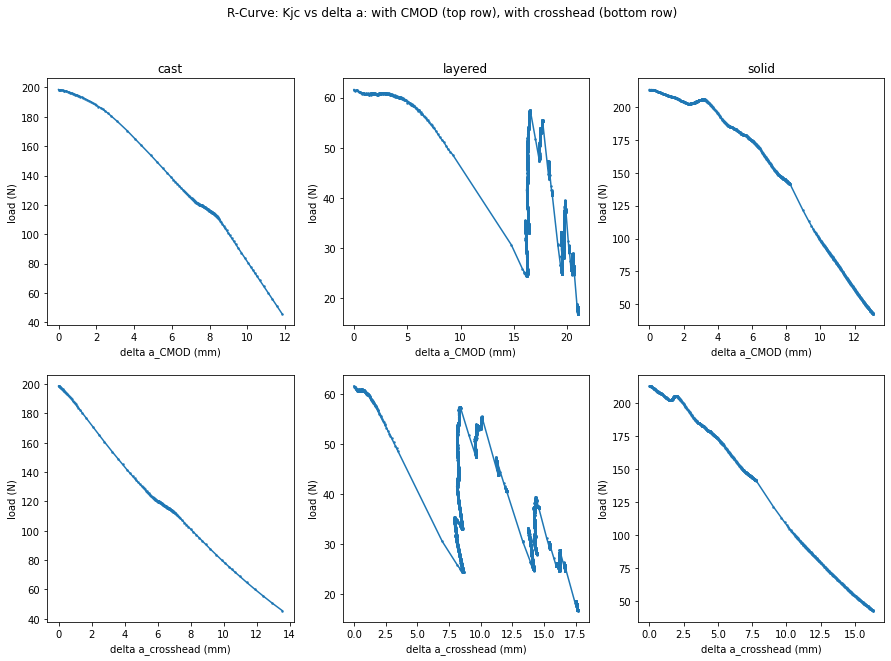

In [212]:
plt.figure(figsize=(15, 10))

plt.suptitle('R-Curve: Kjc vs delta a: with CMOD (top row), with crosshead (bottom row)')

sub = plt.subplot(2, 3, 1)
notched_cast_6.plot('a_CMOD', 'load_pl_normalized', sub)
plt.title('cast')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 2)
notched_layered_4.plot('a_CMOD', 'load_pl_normalized', sub)
plt.title('layered')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 3)
notched_solid_5.plot('a_CMOD', 'load_pl_normalized', sub)
plt.title('solid')
plt.xlabel('delta a_CMOD (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 4)
notched_cast_6.plot('a_crosshead', 'load_pl_normalized', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 5)
notched_layered_4.plot('a_crosshead', 'load_pl_normalized', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('load (N)')

sub = plt.subplot(2, 3, 6)
notched_solid_5.plot('a_crosshead', 'load_pl_normalized', sub)
plt.xlabel('delta a_crosshead (mm)')
plt.ylabel('load (N)')


Text(0, 0.5, 'load (N)')

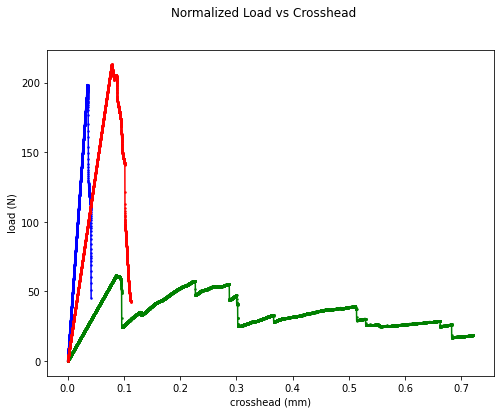

In [214]:
plt.figure(figsize=(8, 6))

plt.suptitle('Normalized Load vs Crosshead')

sub = plt.subplot(1, 1, 1)
notched_cast_6.plot('crosshead_linearized', 'load_linearized_normalized', sub, c='b')
notched_layered_4.plot('crosshead_linearized', 'load_linearized_normalized', sub, c='g')
notched_solid_5.plot('crosshead_linearized', 'load_linearized_normalized', sub, c='r')
plt.xlabel('crosshead (mm)')
plt.ylabel('load (N)')

Text(0, 0.5, 'load (N)')

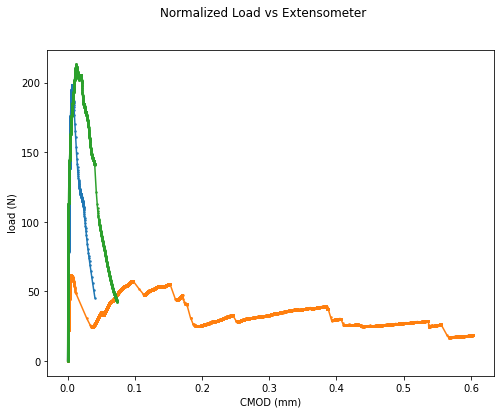

In [201]:
plt.figure(figsize=(8, 6))

plt.suptitle('Normalized Load vs Extensometer')

sub = plt.subplot(1, 1, 1)
notched_cast_6.plot('extenso', 'load_linearized_normalized', sub)
notched_layered_4.plot('extenso', 'load_linearized_normalized', sub)
notched_solid_5.plot('extenso', 'load_linearized_normalized', sub)
plt.xlabel('CMOD (mm)')
plt.ylabel('load (N)')

Text(0, 0.5, 'load (N)')

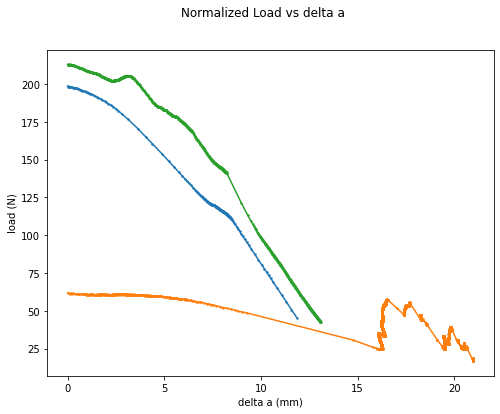

In [202]:
plt.figure(figsize=(8, 6))

plt.suptitle('Normalized Load vs delta a')

sub = plt.subplot(1, 1, 1)
notched_cast_6.plot('a_CMOD', 'load_pl_normalized', sub)
notched_layered_4.plot('a_CMOD', 'load_pl_normalized', sub)
notched_solid_5.plot('a_CMOD', 'load_pl_normalized', sub)
plt.xlabel('delta a (mm)')
plt.ylabel('load (N)')

Text(0, 0.5, 'Kjc')

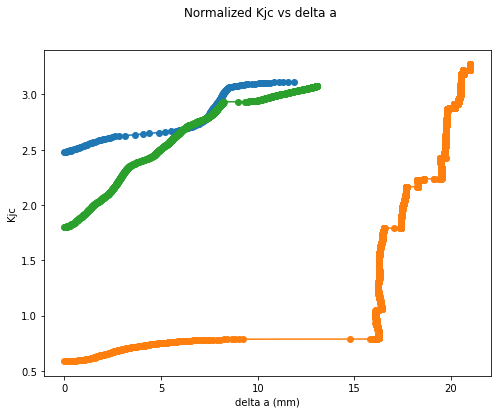

In [14]:
plt.figure(figsize=(8, 6))

plt.suptitle('Normalized Kjc vs delta a')

sub = plt.subplot(1, 1, 1)
notched_cast_6.plot('a_CMOD', 'K_jc_normalized', sub)
notched_layered_4.plot('a_CMOD', 'K_jc_normalized', sub)
notched_solid_5.plot('a_CMOD', 'K_jc_normalized', sub)
plt.xlabel('delta a (mm)')
plt.ylabel('Kjc')

In [15]:
print("cast:    P_max = {}, K_ic = {}, K_jc = {}".format(notched_cast_6.P_max, notched_cast_6.K_ic_normalized, notched_cast_6.K_jc_overall_normalized))
print("layered: P_max = {}, K_ic = {}, K_jc = {}".format(notched_layered_4.P_max, notched_layered_4.K_ic_normalized, notched_layered_4.K_jc_overall_normalized))
print("single:  P_max = {}, K_ic = {}, K_jc = {}".format(notched_solid_5.P_max, notched_solid_5.K_ic_normalized, notched_solid_5.K_jc_overall_normalized))

cast:    P_max = 198.5770721, K_ic = 2.4834703324052336, K_jc = 3.112110852016871
layered: P_max = 47.43473816, K_ic = 0.5898357393639023, K_jc = 3.2709475773697174
single:  P_max = 213.024765, K_ic = 1.7963090102440313, K_jc = 3.0761381328256383
